In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve

# Import Data

In [2]:
df = pd.read_csv('Cleaned_Data2.csv')

In [3]:
# def get_installment_and_terms(row):
#     return int(row['term'][:3])*row['installment']
# def get_returns(row):
#     return round(row['loan_amnt']*((1+((row['int_rate']/100)/12))**(int(row['term'][:3])/2)),2)
# def get_annualized_returns(row):
#     return row['returns']-row['loan_amnt']

In [4]:
# #create the return variables based on above definitions
# df['returns'] = df.apply (lambda row: get_returns(row), axis=1)
# df['installments_and_terms'] = df.apply (lambda row: get_installment_and_terms(row), axis=1)
# df['annualized_returns'] = df.apply (lambda row: get_annualized_returns(row), axis=1)

# Data Adjustment

In [5]:
#change the 'object' categories to 'category'
df2 = df.select_dtypes(include='object')
categorical_features = list(df2.columns)
for col in categorical_features:
    df[col] = df[col].astype('category')

In [6]:
#remove the former 'id' column
df = df.drop('Unnamed: 0', axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872097 entries, 0 to 872096
Data columns (total 65 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   mths_since_recent_inq       872097 non-null  float64 
 1   emp_length                  872097 non-null  category
 2   num_tl_120dpd_2m            872097 non-null  float64 
 3   mo_sin_old_il_acct          872097 non-null  float64 
 4   percent_bc_gt_75            872097 non-null  float64 
 5   mths_since_recent_bc        872097 non-null  float64 
 6   revol_util                  872097 non-null  float64 
 7   dti                         872097 non-null  float64 
 8   debt_settlement_flag        872097 non-null  category
 9   disbursement_method         872097 non-null  category
 10  total_bc_limit              872097 non-null  float64 
 11  total_bal_ex_mort           872097 non-null  float64 
 12  tax_liens                   872097 non-null  float64 
 13 

In [8]:
df.loan_status.value_counts()

Fully Paid     693097
Charged Off    179000
Name: loan_status, dtype: int64

In [9]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['returns', 'installments_and_terms', 'annualized_returns'], axis=1).columns
categorical_features = df.select_dtypes(include=['category']).drop(['loan_status'], axis=1).columns

print(numeric_features)
print(categorical_features)

Index(['mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct',
       'percent_bc_gt_75', 'mths_since_recent_bc', 'revol_util', 'dti',
       'total_bc_limit', 'total_bal_ex_mort', 'tax_liens',
       'pub_rec_bankruptcies', 'num_tl_90g_dpd_24m', 'num_tl_30dpd',
       'num_rev_tl_bal_gt_0', 'total_rec_late_fee', 'num_il_tl',
       'num_accts_ever_120_pd', 'tot_coll_amt', 'acc_now_delinq',
       'num_bc_sats', 'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_old_rev_tl_op', 'delinq_amnt', 'chargeoff_within_12_mths',
       'acc_open_past_24mths', 'mort_acc', 'policy_code',
       'collections_12_mths_ex_med', 'last_fico_range_high',
       'collection_recovery_fee', 'num_rev_accts', 'num_tl_op_past_12m',
       'total_rec_int', 'loan_amnt', 'fico_range_high', 'total_acc',
       'revol_bal', 'open_acc', 'pub_rec', 'out_prncp_inv', 'inq_last_6mths',
       'pct_tl_nvr_dlq', 'avg_cur_bal', 'delinq_2yrs', 'int_rate',
       'annual_inc', 'installment', 'libor'],
    

In [10]:
#check for null variables
df.isnull().sum()

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64

In [11]:
#total number of null values
df.isnull().sum().sum()

0

In [12]:
# #this cell takes >10 minutes to run, so can't run this on full data sheet
# #impute numeric values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
# imputer = imputer.fit(df[numeric_features.tolist()])
# df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])
# #impute categorical values
# imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
# df[categorical_features] = imputerCat.fit_transform(df[categorical_features.tolist()])
# print(df.isnull().sum())

In [13]:
# Create a function we can simply call to generate all the metrics and graph we need
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [14]:
samples = list()
allRows = df.index.values
for i in range(5):
    choices = np.random.choice(allRows, 50000, replace=False)
    samples.append(choices)
    allRows = np.setdiff1d(allRows, choices)

## Sample of 50,000

In [15]:
data = df.copy().iloc[samples[0],:]
data.isnull().sum()

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64

In [16]:
#impute numeric values
#imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
#imputer = imputer.fit(data[numeric_features.tolist()])
#data[numeric_features.tolist()] = imputer.transform(data[numeric_features.tolist()])

#impute categorical values
#imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
#data[categorical_features] = imputerCat.fit_transform(data[categorical_features.tolist()])

#print(data.isnull().sum())

# AdaBoost Classifier (for Loan Default)

In [17]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.loan_status

#used to get dummy variables
X = pd.get_dummies(X)
repmap={"Fully Paid": 1, "Charged Off": 0}
y.replace(repmap, inplace=True)

In [18]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

#remove random state eventually

In [19]:
dt = DecisionTreeClassifier(
    max_depth=1 
    , criterion='gini' 
    , min_samples_leaf = 10 
    , splitter = 'random'
#     , random_state=42
)

adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=25)
adb_clf.fit(X_train, y_train)

# Predict the test data
y_pred = adb_clf.predict(X_test)

0.9441
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      2056
           1       0.95      0.98      0.97      7944

    accuracy                           0.94     10000
   macro avg       0.93      0.89      0.91     10000
weighted avg       0.94      0.94      0.94     10000



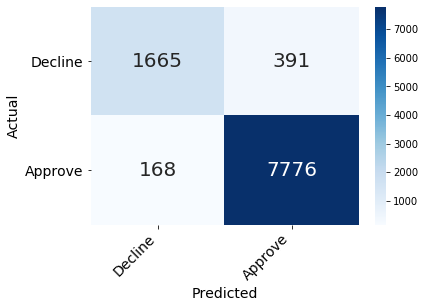

In [20]:
#accuracy score
print(accuracy_score(y_test, y_pred))

#confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

#precision, recall and f1-score
print(classification_report(y_test, y_pred))

Recall Test: 0.98 Train: 0.98
Precision Test: 0.95 Train: 0.95
Roc Test: 0.98 Train: 0.98


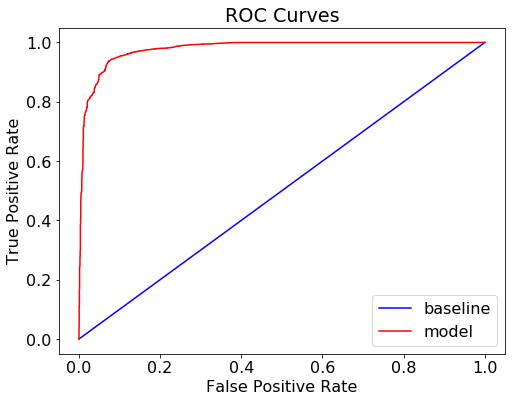

In [21]:
# Evaluating model performance unsing AUC
train_probs = adb_clf.predict_proba(X_train)[:, 1]
probs = adb_clf.predict_proba(X_test)[:, 1]
train_predictions = adb_clf.predict(X_train)
predictions = adb_clf.predict(X_test)
ada_AUC=roc_auc_score(y_test, probs)

evaluate_model(predictions, probs, train_predictions, train_probs)

# Stochastic Gradient Boosting (for Annualized Returns)

In [22]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.annualized_returns

#used to get dummy variables
X = pd.get_dummies(X)

In [23]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

#remove random state eventually

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=100
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 5836.90


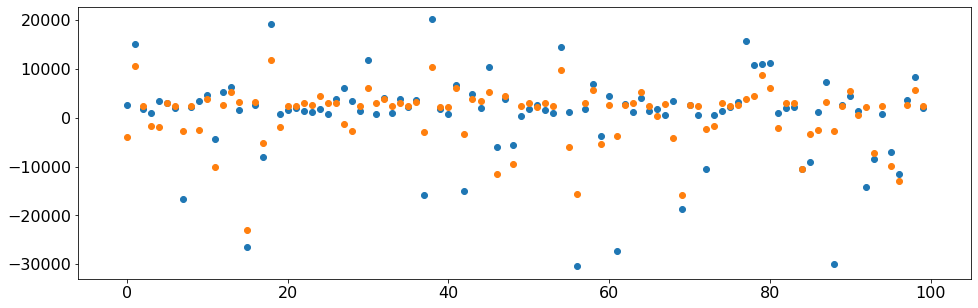

In [25]:
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
# y_test.values.tolist()

plt.scatter(x, y_test[:limit])
plt.scatter(x, y_pred[:limit])

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

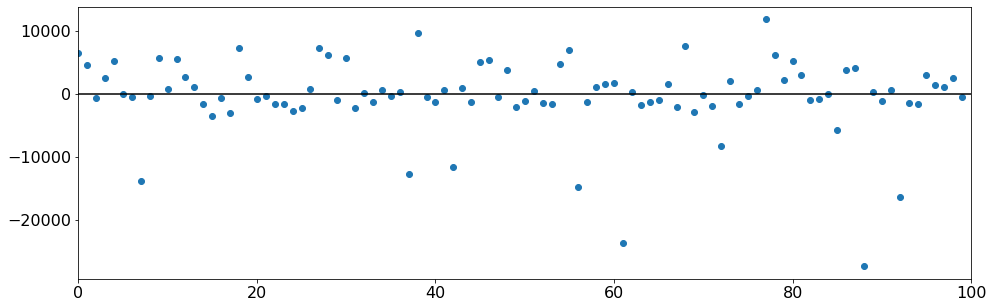

In [26]:
#showing the difference plotted instead of each variable
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
y_plot = y_test-y_pred
# print(np.mean(y_plot))

plt.scatter(x, y_plot[:limit])
plt.hlines(0, xmin=0, xmax=limit)

plt.xlim(0,limit)

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

# Modeling with Percent Return

In [27]:
data = df.copy().iloc[samples[1],:]
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=200
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 0.26


In [30]:
from sklearn import metrics, model_selection
def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(y_test, y_pred)
    msa = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    
    # this creates a chart plotting predicted and actual 
    plt.figure(figsize=(12,6))
    plt.scatter(y_test, y_pred)
    plt.xlabel("Percent Return: $y_i$")
    plt.ylabel("Predicted percent return: $\hat{y}_i$")
    plt.title("Percent Return vs Predicted Percent Return: $y_i$ vs $\hat{y}_i$")

Mean squared error:  0.06805339289541971
Mean absolute error:  0.1401671782181017
R^2 :  0.7113759673224189


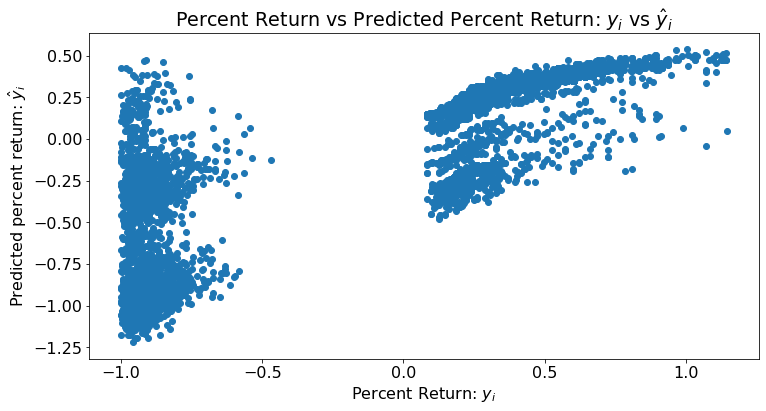

In [31]:
evaluate(y_test,y_pred)

C:\Users\Cecilia_Z\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Mean squared error:  0.06590491120548657
Mean absolute error:  0.1399800937878338
R^2 :  0.7204879810384048
{'max_depth': 1, 'max_features': 0.67, 'n_estimators': 200, 'subsample': 0.33}
0.726494247960105


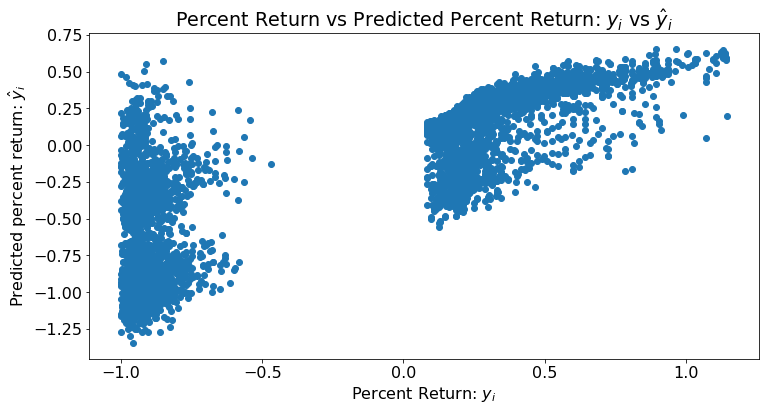

In [32]:
params = {'max_depth':[1], 'subsample':[0.33], 'max_features':[0.5,0.67], 'n_estimators':[100,200]}

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

In [33]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]



In [39]:
#!pip install xgboost
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))


Test set RMSE: 0.22


Mean squared error:  0.04879268553416073
Mean absolute error:  0.10091913419623588
R^2 :  0.7930633424011637


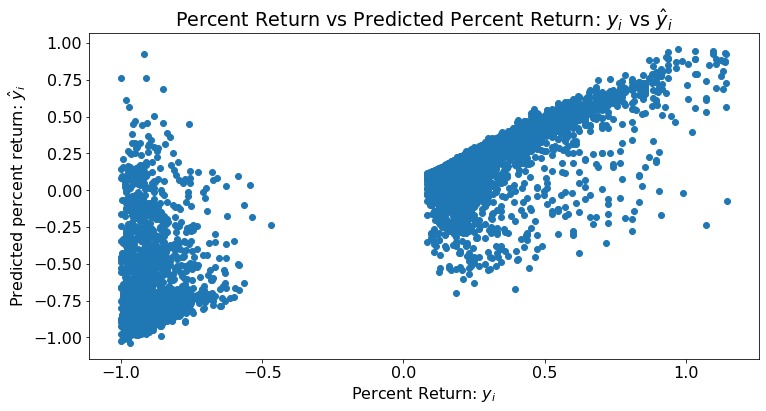

In [40]:
evaluate(y_test,y_pred)

I have not yet done hyperparameter tuning but this is a template. It will take a while to run so we can reduce the number of values we try out

In [ ]:
params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

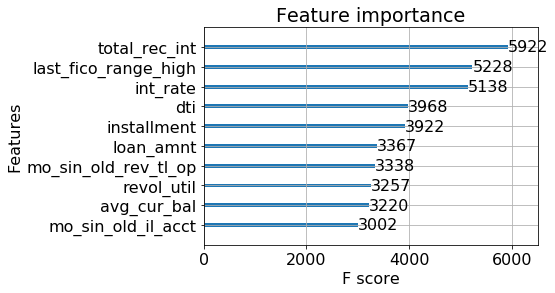

In [41]:
xgb.plot_importance(xg_reg,max_num_features=10)
plt.show()

# Model to Predict Percent Return on Fully Paid Loans

In [42]:
data = df[df['loan_status']=='Fully Paid'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [44]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]



In [45]:
import xgboost as xgb
xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg2.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg2.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))


Test set RMSE: 0.01


Mean squared error:  0.00013212184505294696
Mean absolute error:  0.0073350199244761145
R^2 :  0.9951237406254927


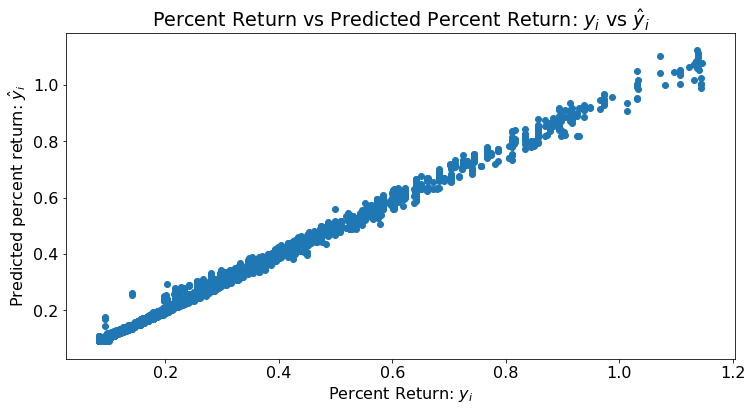

In [46]:
evaluate(y_test,y_pred)

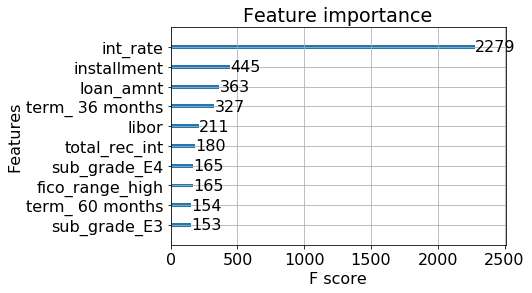

In [47]:
xgb.plot_importance(xg_reg2,max_num_features=10)
plt.show()

# Model to Predict Percent Return on Defaulted Loans

In [48]:
data = df[df['loan_status']=='Charged Off'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [50]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]



In [51]:
import xgboost as xgb
xg_reg3 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg3.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg3.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))


Test set RMSE: 0.02


Mean squared error:  0.0005272995828350415
Mean absolute error:  0.01783546099907371
R^2 :  0.9085922234241559


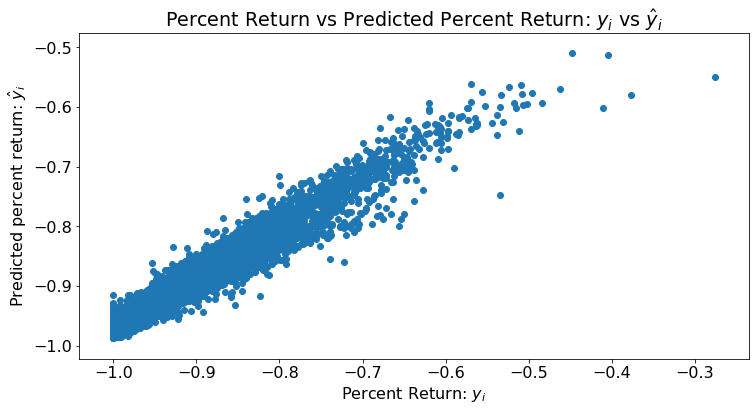

In [52]:
evaluate(y_test,y_pred)

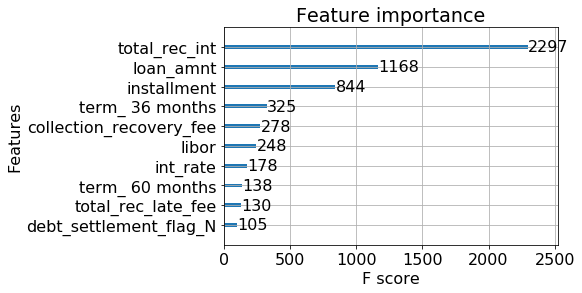

In [53]:
xgb.plot_importance(xg_reg3,max_num_features=10)
plt.show()

# Comparison of 3 Strategies

adb_clf for classifying default

xg_reg for predicting return on all loans

xg_reg2 for predicting return on FP loans, xg_reg3 for predicting return on Defaulted loans

In [67]:
data = pd.concat([df.copy().iloc[samples[2],:],df.copy().iloc[samples[3],:],df.copy().iloc[samples[4],:],])
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
X = pd.get_dummies(X)
y = data.percent_return

# Method 1: Using the Default Model (Result: ~15% return)

In [68]:
prediction1 = pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid'])
prediction1['percent_return'] = y.values

# These are the loans we pick
prediction1.nlargest(1000,'Fully Paid')

,Default,Fully Paid,percent_return
41676,0.408839,0.591161,0.318008
104128,0.408839,0.591161,0.323665
148564,0.411389,0.588611,0.318010
38212,0.411961,0.588039,0.138352
42514,0.411961,0.588039,0.160940
...,...,...,...
102042,0.419850,0.580150,0.112360
102953,0.419850,0.580150,0.155426
103068,0.419850,0.580150,0.097854
106660,0.419850,0.580150,0.094419


In [69]:
# Percent return by this strategy
np.mean(prediction1.nlargest(1000,'Fully Paid').percent_return)

0.15561676266180544

Text(0.5, 1.0, 'Default Model Profolio Return distribution')

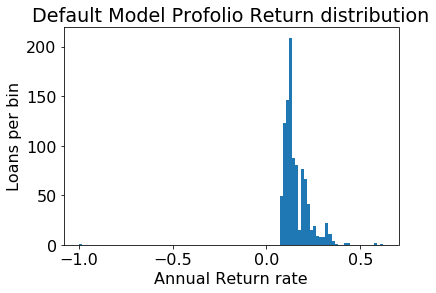

In [85]:
plt.hist(prediction1.nlargest(1000,'Fully Paid')['percent_return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Default Model Profolio Return distribution')

# Method 2: Using the return model (Result: ~95% Return)

In [71]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]


In [72]:
prediction2 = pd.DataFrame(xg_reg.predict(X),columns=['Predicted Return'])
prediction2['Actual Return'] = y.values
# These are the loans we pick
prediction2.nlargest(1000,'Predicted Return')

,Predicted Return,Actual Return
39716,1.114881,1.138363
6258,1.093617,1.138363
18238,1.079670,1.097056
6550,1.074653,1.097056
6981,1.073037,1.138363
...,...,...
35284,0.722880,0.916773
25081,0.722490,0.855833
81752,0.722489,0.798090
68764,0.722473,0.893929


In [73]:
np.mean(prediction2.nlargest(1000,'Predicted Return')['Actual Return'])

0.9424980361887297

Text(0.5, 1.0, 'Return Model Profolio Return distribution')

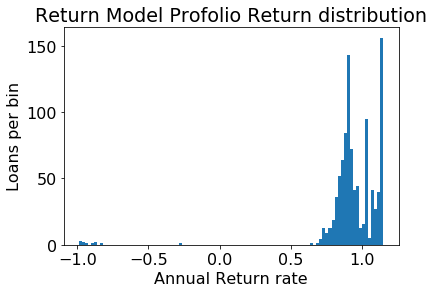

In [81]:
plt.hist(prediction2.nlargest(1000,'Predicted Return')['Actual Return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Return Model Profolio Return distribution')

# Method 3: Using the Combined Approach (Result: ~83% Return)

In [62]:
prediction3 = pd.concat([pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid']),
           pd.DataFrame(xg_reg2.predict(X),columns=['Fully Paid Predicted Return']),
          pd.DataFrame(xg_reg3.predict(X),columns=['Defaulted Predicted Return'])],axis=1)

In [63]:
prediction3['Expected Return']=prediction3['Default']*prediction3['Defaulted Predicted Return']+prediction3['Fully Paid']*prediction3['Fully Paid Predicted Return']

prediction3['Actual Return'] = y.values

In [64]:
# These are the loans we pick
prediction3.nlargest(1000,'Expected Return')

,Default,Fully Paid,Fully Paid Predicted Return,Defaulted Predicted Return,Expected Return,Actual Return
111094,0.449850,0.550150,1.041122,-0.632301,0.288333,1.006427
62175,0.437184,0.562816,1.110961,-0.788502,0.280546,1.122781
19276,0.448817,0.551183,1.042907,-0.660631,0.278330,1.148811
95019,0.449850,0.550150,1.062273,-0.682050,0.277590,1.097056
55665,0.472301,0.527699,1.141414,-0.714684,0.264777,1.138363
...,...,...,...,...,...,...
125528,0.465746,0.534254,0.742871,-0.639227,0.099164,0.767054
28055,0.443270,0.556730,0.840851,-0.832394,0.099152,0.855833
43055,0.472301,0.527699,0.842288,-0.731204,0.099126,0.816251
51445,0.462436,0.537564,0.846644,-0.769923,0.099086,0.855833


In [65]:
np.mean(prediction3.nlargest(1000,'Expected Return')['Actual Return'])

0.8152748471037053

Text(0.5, 1.0, 'Return Model Profolio Return distribution')

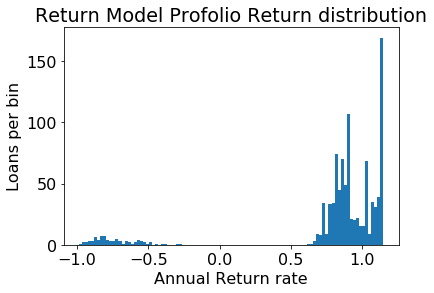

In [84]:
plt.hist(prediction3.nlargest(1000,'Expected Return')['Actual Return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Combination Model Profolio Return distribution')

Text(0, 0.5, 'Return Rate')

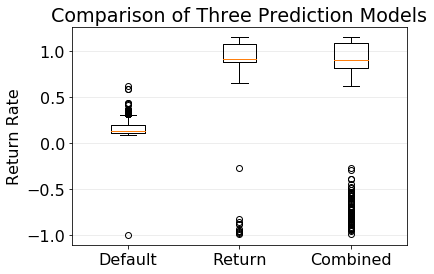

In [102]:
my_dict = {'Default': prediction1.nlargest(1000,'Fully Paid')['percent_return'], 'Return': prediction2.nlargest(1000,'Predicted Return')['Actual Return'], 'Combined':prediction3.nlargest(1000,'Expected Return')['Actual Return']}

fig, ax = plt.subplots()
bplot = ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.set_axisbelow(True)
ax.set_title('Comparison of Three Prediction Models')
ax.set_ylabel('Return Rate')